# API
- env.render()：將環境畫出來，方便從肉眼觀察訓練情況。不過會大幅降低訓練速度，如果想加速可以不用，或是 render 出來後把視窗點掉。
- env.observation_space：state 的設置，例如上下界等等。
- env.action_space：action 的設置，也提供 sample() method 可以隨機選擇 action。
- env.reset()：重置環境，一回合重新開始。
- env.step(action)：在環境中做出 action。會回傳 observation、rewards、done 回合結束與否、及 info 其他資訊。
- env.close()：完成訓練後把環境完整關閉。
---
- Agent：小車控制系統。
- Environment：CartPole。
- State：四種 feature：車子位置（1D）、車子速度、柱子角度、柱子角速度。
- Action：將車子向左或向右控制。
- Reward：每個 timestep 如果柱子還站著則 +1。如果柱子太歪或車子跑太遠就結束一回合，所以每一回合站越久總 reward 就越大。

# 改變 max episode steps
gym 模擬器的模擬暫存現在預設次數最大只能到 200，因此要有如上的幾萬次模擬需自己改變模擬器設定 (https://github.com/openai/gym/issues/463)

一個可行的方法如下：
```
env = gym.make("CartPole-v0")
env._max_episode_steps = 500
```

In [40]:
import gym
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [47]:
# RL 訓練長度
N_EPISODES = 300
EPISODE_LENGTH = 500

# env = gym.make('CartPole-v0') # max episode length : 200
env = gym.make('CartPole-v1') # max episode length : 500

In [42]:
# Gym parameter test

print(env.action_space) # Check dimension of spaces
print(env.observation_space) # Check range of spaces
print(env.observation_space.high)
print(env.observation_space.low)
print(env.action_space.sample())

Discrete(2)
Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
0


In [61]:
def plot_rewards(rewards, n_episodes, algo):
    plt.plot(list(range(n_episodes)), rewards)
    plt.xlabel('episode')
    plt.ylabel('rewards')
    plt.ylim(0, EPISODE_LENGTH+5)
    plt.title('Rewards over episodes ({})'.format(algo))
#     plt.savefig('{}.png'.format('_'.join(algo.split(' '))))

# Random Action

Episode finished after 13 timesteps, total rewards 13.0
Episode finished after 17 timesteps, total rewards 17.0
Episode finished after 18 timesteps, total rewards 18.0
Episode finished after 28 timesteps, total rewards 28.0
Episode finished after 21 timesteps, total rewards 21.0
Episode finished after 21 timesteps, total rewards 21.0
Episode finished after 35 timesteps, total rewards 35.0
Episode finished after 29 timesteps, total rewards 29.0
Episode finished after 18 timesteps, total rewards 18.0
Episode finished after 21 timesteps, total rewards 21.0
Episode finished after 13 timesteps, total rewards 13.0
Episode finished after 15 timesteps, total rewards 15.0
Episode finished after 24 timesteps, total rewards 24.0
Episode finished after 14 timesteps, total rewards 14.0
Episode finished after 20 timesteps, total rewards 20.0
Episode finished after 17 timesteps, total rewards 17.0
Episode finished after 12 timesteps, total rewards 12.0
Episode finished after 21 timesteps, total rewar

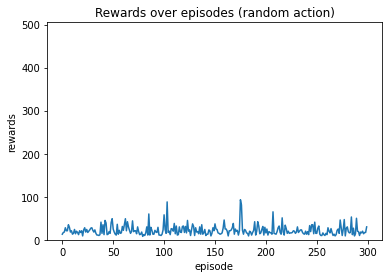

In [62]:
all_rewards = []

for i_episode in range(N_EPISODES):
    observation = env.reset() # reset environment to initial state for each episode
    rewards = 0 # accumulate rewards for each episode
    for t in range(EPISODE_LENGTH):
#         env.render()

        # 隨機挑選 action，這邊是向左或向右
        action = env.action_space.sample()

        # 在環境中做出 action
        observation, reward, done, info = env.step(action)
        
        # 累加 reward
        rewards += reward

        if done: # 回合結束，可能柱子太傾斜或車子跑遠
            print('Episode finished after {} timesteps, total rewards {}'.format(t+1, rewards))
            break
    all_rewards.append(rewards)
            
env.close() # need to close, or errors will be reported
plot_rewards(all_rewards, N_EPISODES, 'random action')
print('Average rewards :', sum(all_rewards)/N_EPISODES)

# Hand-made

Episode finished after 54 timesteps, total rewards 54.0
Episode finished after 39 timesteps, total rewards 39.0
Episode finished after 55 timesteps, total rewards 55.0
Episode finished after 45 timesteps, total rewards 45.0
Episode finished after 58 timesteps, total rewards 58.0
Episode finished after 46 timesteps, total rewards 46.0
Episode finished after 35 timesteps, total rewards 35.0
Episode finished after 45 timesteps, total rewards 45.0
Episode finished after 45 timesteps, total rewards 45.0
Episode finished after 37 timesteps, total rewards 37.0
Episode finished after 39 timesteps, total rewards 39.0
Episode finished after 41 timesteps, total rewards 41.0
Episode finished after 57 timesteps, total rewards 57.0
Episode finished after 39 timesteps, total rewards 39.0
Episode finished after 31 timesteps, total rewards 31.0
Episode finished after 39 timesteps, total rewards 39.0
Episode finished after 42 timesteps, total rewards 42.0
Episode finished after 39 timesteps, total rewar

Average rewards : 42.39333333333333


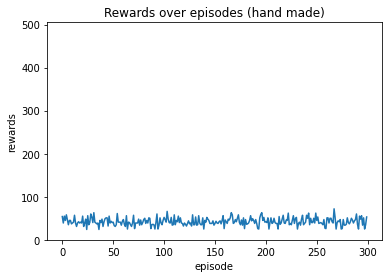

In [63]:
def choose_action(observation):
    pos, v, ang, rot = observation
    return 0 if ang < 0 else 1 # a simple rule based only on angles

all_rewards = []
for i_episode in range(N_EPISODES):
    observation = env.reset() # reset environment to initial state for each episode
    rewards = 0 # accumulate rewards for each episode
    for t in range(EPISODE_LENGTH):
#         env.render()

        action = choose_action(observation) # choose an action based on hand-made rule 
        observation, reward, done, info = env.step(action) # do the action, get the reward
        rewards += reward

        if done:
            print('Episode finished after {} timesteps, total rewards {}'.format(t+1, rewards))
            break
    all_rewards.append(rewards)

env.close() # need to close, or errors will be reported
plot_rewards(all_rewards, N_EPISODES, 'hand made')
print('Average rewards :', sum(all_rewards)/N_EPISODES)

# Q-Table
[參考資料](https://github.com/pyliaorachel/knock-knock-deep-learning/blob/master/day-25/cartpole/q_table/main.py)

In [64]:
def choose_action(state, q_table, action_space, epsilon):
    if np.random.random_sample() < epsilon: # random action
        return action_space.sample() 
    else: # greedy action based on Q table, 其他時間根據現有 policy 選擇 action，也就是在 Q table 裡目前 state 中，選擇擁有最大 Q value 的 action
        return np.argmax(q_table[state])

def get_state(observation, n_buckets, state_bounds):
    state = [0] * len(observation)
    for i, s in enumerate(observation):
        l, u = state_bounds[i][0], state_bounds[i][1] # lower- and upper-bounds for each feature in observation
        if s <= l:  # 低於下界屬於第 1 個 bucket
            state[i] = 0
        elif s >= u: # 高於下界屬於最後一個 bucket
            state[i] = n_buckets[i] - 1
        else: # 其他看你在哪個區間，決定你在哪個 bucket
            state[i] = int(((s - l) / (u - l)) * n_buckets[i])

    return tuple(state)


Episode finished after 16 timesteps, total rewards 16.0
Episode finished after 19 timesteps, total rewards 19.0
Episode finished after 22 timesteps, total rewards 22.0
Episode finished after 43 timesteps, total rewards 43.0
Episode finished after 25 timesteps, total rewards 25.0
Episode finished after 11 timesteps, total rewards 11.0
Episode finished after 34 timesteps, total rewards 34.0
Episode finished after 21 timesteps, total rewards 21.0
Episode finished after 25 timesteps, total rewards 25.0
Episode finished after 44 timesteps, total rewards 44.0
Episode finished after 53 timesteps, total rewards 53.0
Episode finished after 11 timesteps, total rewards 11.0
Episode finished after 42 timesteps, total rewards 42.0
Episode finished after 12 timesteps, total rewards 12.0
Episode finished after 35 timesteps, total rewards 35.0
Episode finished after 17 timesteps, total rewards 17.0
Episode finished after 14 timesteps, total rewards 14.0
Episode finished after 27 timesteps, total rewar

Episode finished after 500 timesteps, total rewards 500.0
Episode finished after 467 timesteps, total rewards 467.0
Episode finished after 500 timesteps, total rewards 500.0
Episode finished after 14 timesteps, total rewards 14.0
Episode finished after 32 timesteps, total rewards 32.0
Episode finished after 78 timesteps, total rewards 78.0
Episode finished after 17 timesteps, total rewards 17.0
Episode finished after 405 timesteps, total rewards 405.0
Episode finished after 500 timesteps, total rewards 500.0
Episode finished after 500 timesteps, total rewards 500.0
Episode finished after 468 timesteps, total rewards 468.0
Episode finished after 500 timesteps, total rewards 500.0
Episode finished after 500 timesteps, total rewards 500.0
Episode finished after 324 timesteps, total rewards 324.0
Episode finished after 303 timesteps, total rewards 303.0
Episode finished after 500 timesteps, total rewards 500.0
Episode finished after 500 timesteps, total rewards 500.0
Episode finished after

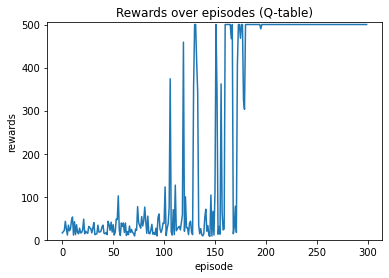

In [65]:
# Preparing Q table
## buckets for continuous state values to be assigned to
n_buckets = (1, 1, 6, 3) # Observation space: [position of cart, velocity of cart, angle of pole, rotation rate of pole]
                         # Setting bucket size to 1 = ignoring the particular observation state 
                         # angle of pole : range [-0.5, 0.5] separated to 6 intervals

## discrete actions
n_actions = env.action_space.n

## state bounds
state_bounds = list(zip(env.observation_space.low, env.observation_space.high))
state_bounds[1] = [-0.5, 0.5]
state_bounds[3] = [-math.radians(50), math.radians(50)]

## init Q table for each state-action pair
q_table = np.zeros(n_buckets + (n_actions,))

# Learning related constants; factors determined by trial-and-error
get_epsilon = lambda i: max(0.01, min(1, 1.0 - math.log10((i+1)/25))) # epsilon-greedy, factor to explore randomly; discounted over time
get_lr = lambda i: max(0.01, min(0.5, 1.0 - math.log10((i+1)/25))) # learning rate; discounted over time
gamma = 0.99 # reward discount factor

# Q-learning
all_rewards = []
for i_episode in range(N_EPISODES):
    epsilon = get_epsilon(i_episode)
    lr = get_lr(i_episode)

    observation = env.reset() # reset environment to initial state for each episode
    rewards = 0 # accumulate rewards for each episode
    state = get_state(observation, n_buckets, state_bounds) # turn observation into discrete state
    for t in range(EPISODE_LENGTH):
#         env.render()

        # Agent takes action
        action = choose_action(state, q_table, env.action_space, epsilon) # choose an action based on q_table 
        observation, reward, done, info = env.step(action) # do the action, get the reward
        rewards += reward
        next_state = get_state(observation, n_buckets, state_bounds)

        # Agent learns via Q-learning
        q_next_max = np.amax(q_table[next_state])
        q_table[state + (action,)] += lr * (reward + gamma * q_next_max - q_table[state + (action,)])

        # Transition to next state
        state = next_state

        if done:
            print('Episode finished after {} timesteps, total rewards {}'.format(t+1, rewards))
            break
    all_rewards.append(rewards)

env.close() # need to close, or errors will be reported
plot_rewards(all_rewards, N_EPISODES, 'Q-table')
print('Average rewards :', sum(all_rewards)/N_EPISODES)

# [Neuron-like adaptive elements that can solve difficult learning control problems](http://www.derongliu.org/adp/adp-cdrom/Barto1983.pdf)
使用兩個類神經網路結構，配合 Q-learning 演算法，可以解決困難的台車木棒平衡問題。

- 盒系統 (box system) : 把4維的輸入狀態向量 (x, x_dot, theta, theta_dot) 轉成162維的狀態向量，這裡使用的 x, theta 區分值 ( 如 x: ±0.8, ±2.4 m ) 是根據過去的理論經驗。
- 評價系統 (adaptive critic element, ACE) : 產生一個比較好的 reward 訊號，使用 Temporal Difference (TD) 方法。
- 動作系統 (associative search element, ASE) : 使用 box 產生的狀態向量和較好的 reward，產生動作 (向左/右)。

> [參考資料](https://mropengate.blogspot.com/2016/12/q-learning-openai-gym-cart-pole-system.html)

In [44]:
BOX_DIM = 162
N_EPISODES = 500
EPISODE_LENGTH = 1000

x_vec = np.zeros(BOX_DIM) # state vector
w = np.zeros(BOX_DIM)     # action weights
v = np.zeros(BOX_DIM)     # critic weights
e = np.zeros(BOX_DIM)     # action weight eligibilities
x_bar = np.zeros(BOX_DIM) # critic weight eligibilities

def Activation(x):
    # Activation function : [step function]
    if x >= 0: return 1
    else: return 0

def ACE(learn, decay, reward, gamma, p_before):
    # ACE : generate [improved reinforcement signal (reward_hat)]
    global v, x_vec, x_bar
    
    if reward == -1: 
        p = 0
    else: 
        p = v.dot(x_vec)
        
    reward_hat = reward + gamma*p - p_before
    v += learn * reward_hat * x_bar
    x_bar = decay*x_bar + (1-decay)*x_vec
    
    return reward_hat, p

def ASE(learn, decay, reward):
    # ASE : generate [action]
    global w, x_vec, e
    
    sigma = 0.01
    noise = sigma*np.random.randn()
    
    y = Activation(w.dot(x_vec) + noise)
    w += learn * reward * e
    e = decay*e + (1-decay)*(y*2-1)*x_vec

    return y

def Box(ob):
    # box system : [4-dim state] to [162-dim state] 
    x, x_dot, theta, theta_dot = ob
    box = 0
    
    one_degree = 0.0174532
    six_degrees = 0.1047192
    twelve_degrees = 0.2094384
    fifty_degrees = 0.87266

    if x < -2.4 or x > 2.4  or theta < -1*twelve_degrees or theta > twelve_degrees :
        return Box([0,0,0,0])

    if x < -0.8 : box = 0
    elif x < 0.8 : box = 1
    else: box = 2

    if x_dot < -0.5 : box = box
    elif x_dot < 0.5 : box += 3
    else: box += 6
    
    if theta < -1*six_degrees : box = box
    elif theta < -1*one_degree : box += 9
    elif theta < 0: box += 18
    elif theta < one_degree : box += 27
    elif theta < six_degrees : box += 36
    else : box += 45

    if theta_dot < -fifty_degrees : box = box
    elif theta_dot < fifty_degrees : box += 54
    else : box += 108

    state = np.zeros(BOX_DIM)
    state[box] = 1

    return state

In [45]:
def ttplot_rewards(rewards, n_episodes, algo):
    plt.plot(list(range(n_episodes)), rewards)
    plt.xlabel('episode')
    plt.ylabel('rewards')
    plt.ylim(-1,1)
    plt.title('Rewards over episodes ({})'.format(algo))

Episode    0 was    15 steps
Reward -1.00
Episode   10 was    10 steps
Reward -0.53
Episode   20 was   160 steps
Reward -0.70
Episode   30 was   208 steps
Reward -0.82
Episode   40 was   273 steps
Reward -0.97
Episode   50 was   369 steps
Reward -0.64
Episode   60 was   569 steps
Reward -0.82
Episode   70 was   484 steps
Reward -0.90
Episode   80 was   999 steps
Reward -0.99
Episode   90 was   999 steps
Reward -1.00
Episode  100 was   999 steps
Reward -0.98
Episode  110 was   999 steps
Reward -0.99
Episode  120 was   999 steps
Reward -0.98
Episode  130 was   999 steps
Reward -0.43
Episode  140 was   999 steps
Reward -0.99
Episode  150 was   999 steps
Reward -0.98
Episode  160 was   999 steps
Reward -0.98
Episode  170 was   999 steps
Reward -0.98
Episode  180 was   999 steps
Reward -0.98
Episode  190 was   999 steps
Reward -0.98
Episode  200 was   999 steps
Reward -0.99
Episode  210 was   999 steps
Reward -0.99
Episode  220 was   999 steps
Reward -0.97
Episode  230 was   999 steps
Rewar

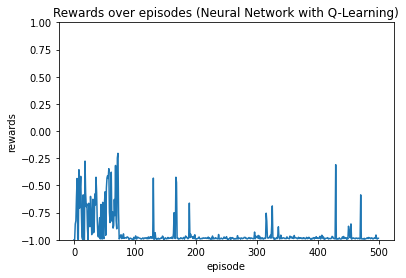

In [46]:
env = gym.make('CartPole-v1')
env._max_episode_steps = 1000
all_rewards = []
for i in range(0, N_EPISODES):
    ob = env.reset()
    p_before = 0
        
    for j in range(0, EPISODE_LENGTH):
        x_vec = Box(ob)
        reward_hat, p_before = ACE(learn=0.5, decay=0.8, reward=0, gamma=0.95, p_before=p_before)
        action = ASE(learn=1000, decay=0.9, reward=reward_hat)
     
        if j > 9000: 
            env.render()
         
        ob, _, done, _ = env.step(action)

        if done:
            x_vec = Box(ob)
            reward_hat, p_before = ACE(learn=0.5, decay=0.8, reward=-1, gamma=0.95, p_before=p_before)
            ASE(learn=1000, decay=0.9, reward=reward_hat)
            break
    all_rewards.append(reward_hat)
    
    if i % 10 == 0 :
        print("Episode  {0:3} was {1:5} steps".format(i, j))
        print("Reward {:.2f}".format(reward_hat))
#     if j == MAX_STEPS-1 :
#      print("Pole balanced successfully for at least {} steps at Trail {}".format(MAX_STEPS, i))
#      break

env.close()
ttplot_rewards(all_rewards, N_EPISODES, 'Neural Network with Q-Learning')

# Mountain Car
[參考資料](https://www.twblogs.net/a/5d21b243bd9eee1e5c83bef5)

In [79]:
LEARNING_RATE = 0.5
DISCOUNT = 0.95
EPISODES = 5000
SHOW_EVERY = 200
Q_TABLE_LEN = 20

env = gym.make('MountainCar-v0')

In [71]:
print(env.action_space) # Check dimension of spaces
print(env.observation_space) # Check range of spaces
print(env.observation_space.high)
print(env.observation_space.low)
print(env.action_space.sample())

Discrete(3)
Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)
[0.6  0.07]
[-1.2  -0.07]
0


episode: 0
episode: 200
episode: 400
episode: 600
episode: 800
episode: 1000
episode: 1200
episode: 1400
episode: 1600
episode: 1800
episode: 2000
episode: 2200
episode: 2400
episode: 2600
episode: 2800
episode: 3000
episode: 3200
episode: 3400
episode: 3600
episode: 3800
episode: 4000
episode: 4200
episode: 4400
episode: 4600
episode: 4800


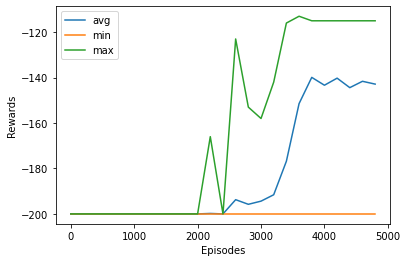

In [80]:
env.reset()
DISCRETE_OS_SIZE = [Q_TABLE_LEN] * len(env.observation_space.high)
discrete_os_win_size = (env.observation_space.high - env.observation_space.low) / DISCRETE_OS_SIZE

q_table = np.zeros(DISCRETE_OS_SIZE + [env.action_space.n])

epsilon = 1  # not a constant, qoing to be decayed
START_EPSILON_DECAYING = 1
END_EPSILON_DECAYING = EPISODES//2
epsilon_decay_value = epsilon/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)

def get_discrete_state (state):
    discrete_state = (state - env.observation_space.low) // discrete_os_win_size
    return tuple(discrete_state.astype(int))

def take_epilon_greedy_action(state, epsilon):
    discrete_state = get_discrete_state(state)
    if np.random.random() < epsilon:
        action = np.random.randint(0,env.action_space.n)
    else:
        action = np.argmax(q_table[discrete_state])
    return action


ep_rewards = []
aggr_ep_rewards = {'ep':[],'avg':[],'min':[],'max':[]}

for episode in range(EPISODES):
    # initiate reward every episode
    ep_reward = 0
    if episode % SHOW_EVERY == 0:
        print("episode: {}".format(episode))
        render = True
    else:
        render = False

    state = env.reset()
    done = False
    while not done:
        action = take_epilon_greedy_action(state, epsilon)
        next_state, reward, done, _ = env.step(action)

        ep_reward += reward


        if not done:

            td_target = reward + DISCOUNT * np.max(q_table[get_discrete_state(next_state)])

            q_table[get_discrete_state(state)][action] += LEARNING_RATE * (td_target - q_table[get_discrete_state(state)][action])

        elif next_state[0] >= 0.5:
            # print("I made it on episode: {} Reward: {}".format(episode,reward))
            q_table[get_discrete_state(state)][action] = 0


        state = next_state

    # Decaying is being done every episode if episode number is within decaying range
    if END_EPSILON_DECAYING >= episode >= START_EPSILON_DECAYING:
        epsilon -= epsilon_decay_value

    # recoard aggrated rewards on each epsoide
    ep_rewards.append(ep_reward)

    # every SHOW_EVERY calculate average rewords
    if episode % SHOW_EVERY == 0:
        avg_reward = sum(ep_rewards[-SHOW_EVERY:]) / len(ep_rewards[-SHOW_EVERY:])
        aggr_ep_rewards['ep'].append(episode)
        aggr_ep_rewards['avg'].append(avg_reward)
        aggr_ep_rewards['min'].append(min(ep_rewards[-SHOW_EVERY:]))
        aggr_ep_rewards['max'].append(max(ep_rewards[-SHOW_EVERY:]))


plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['avg'], label = 'avg')
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['min'], label = 'min')
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['max'], label = 'max')
plt.legend(loc='upper left')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.show()

done = False
state = env.reset()
while not done:
    action = np.argmax(q_table[get_discrete_state(state)])
    next_state, _, done, _ = env.step(action)
    state = next_state
    env.render()

env.close()